In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib.backends.backend_pdf import PdfPages
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from tsfresh import extract_features
import pmdarima as pm
from pmdarima import model_selection

warnings.filterwarnings("ignore")
plt.rcParams["font.size"] = 10


In [41]:

########## Load each data frame into dictionary - Permian ##########
file_names = ! ls permian_despiked_120523
dict_dfs = {}
for file_name in file_names:
    df=pd.read_csv(f'permian_despiked_120523/{file_name}')
    dict_dfs[file_name]=df
    
# these are the cols of interest
consistent_col_names =['DEPTH(ft)',
 'ROP(ft / min)',
 'WOB(klbs)',
 'TPO(gal / min)',
 'RPM(rpm)',
 'SPP(psi)',
 'INC(deg)',
 'Gamma(gapi)',
 'DIFP(psi)']

df=dict_dfs[file_names[0]]
df=df[consistent_col_names].dropna() 

# get horz and vertical drilling separately
df_horz=df[df['INC(deg)']>80]
df_horz_orig = df_horz.copy()
# create ids to represent different windows -30ft
def add_ids(df):
    ids=[]
    window=60 #equivalent to 30ft
    id=0
    for i in range(1,len(df)+1):
        if (i/window).is_integer():
            id=i/window
            ids.append(id)
        else: 
            ids.append(id)
    df['id']=ids
    small_window=pd.Series(ids).value_counts()[pd.Series(ids).value_counts()<99].index[0]
    df= df[df['id']!=small_window] #remove small window
    df['id']=df['id'].astype(int)
    df['DEPTH(ft)_time']=df['DEPTH(ft)']
    return df
df_horz1=add_ids(df_horz)


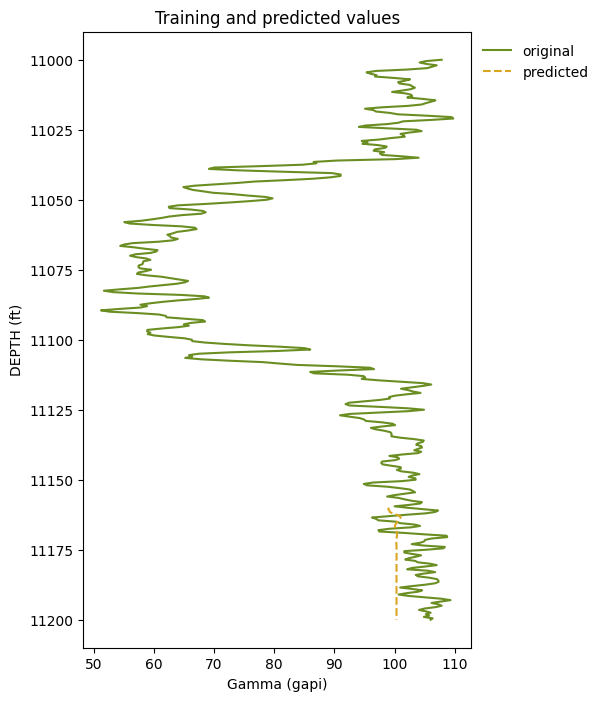

In [42]:
#### predict raw values using non-optimized basic Arima model
df=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']]
df=df[(df['DEPTH(ft)']>=11000)&(df['DEPTH(ft)']<=11200)]
X = df[f'Gamma(gapi)'].values
# split into train and test sets
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = list(train)
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t] #real obs
    history.append(yhat)
#  print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
# rmse='Test RMSE: %.3f' % rmse
# plot forecasts against actual outcomes
fig, ax=plt.subplots(figsize=(5,8))
ax.plot(df['Gamma(gapi)'],df['DEPTH(ft)'], color='olivedrab',label='original')
predictions=pd.Series(predictions)
predictions.index=range(len(train),len(train)+len(predictions))
df=df.reset_index(drop=True)
df[f'pred']=predictions
ax.plot(df['pred'],df[f'DEPTH(ft)'], color='goldenrod',label=f'predicted',alpha=1,linestyle='--')
ax.set_xlabel('Gamma (gapi)')
ax.set_ylabel('DEPTH (ft)')
ax.set_title('Training and predicted values')
ax.invert_yaxis()
ax.legend(frameon=False, bbox_to_anchor=(1,1))


In [24]:
# get one non-overlapping window to simulate simple prediction in windows of 30ft
fc_settings = {'mean': None}
# fc_settings = {'mean': None,'median': None,'minimum': None,'maximum': None,'root_mean_square':None,'standard_deviation':None}
df_features = extract_features(df_horz1, column_id="id", column_sort="DEPTH(ft)_time",default_fc_parameters=fc_settings)
df_features.columns


Feature Extraction:  40%|████      | 4/10 [00:00<00:00, 34.26it/s]

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 39.94it/s]


Index(['DEPTH(ft)__mean', 'ROP(ft / min)__mean', 'WOB(klbs)__mean',
       'TPO(gal / min)__mean', 'RPM(rpm)__mean', 'SPP(psi)__mean',
       'INC(deg)__mean', 'Gamma(gapi)__mean', 'DIFP(psi)__mean'],
      dtype='object')

In [43]:
### get overlapping .5ft windows to simulate re-train every .5ft
fc_settings = {'mean': None,'median': None,'minimum': None,'maximum': None,'root_mean_square':None,'standard_deviation':None}
# fc_settings = {'mean': None}
dfs=[]
for i in range(0,60):
    df_shift = add_ids(df_horz_orig.iloc[i:])
    df_features = extract_features(df_shift, column_id="id", column_sort="DEPTH(ft)_time",default_fc_parameters=fc_settings)
    dfs.append(df_features)

Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 30.52it/s]


NameError: name 'dfs' is not defined

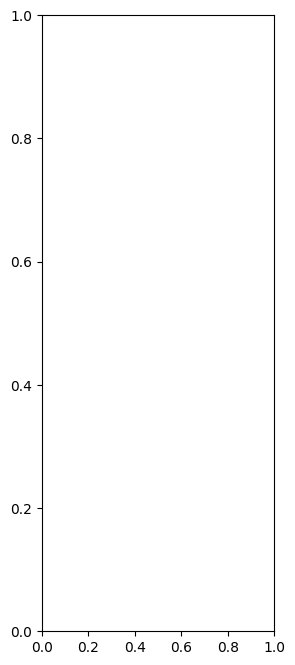

In [25]:
# visualize overlapping window input data
fig, ax=plt.subplots(figsize=(3,8))
df=pd.concat(dfs)
df=df.sort_values('DEPTH(ft)__mean')
df=df[(df['DEPTH(ft)__mean']>=11000)&(df['DEPTH(ft)__mean']<=11200)]
ax.plot(df['Gamma(gapi)__mean'],df['DEPTH(ft)__mean'], color='navy',label='Mean over 30ft - overlapping')
ax.set_xlabel('Gamma (gapi)\nmean 30ft window\noverlapping')
ax.set_ylabel('DEPTH (ft)')
ax.invert_yaxis()


15.848753274844372


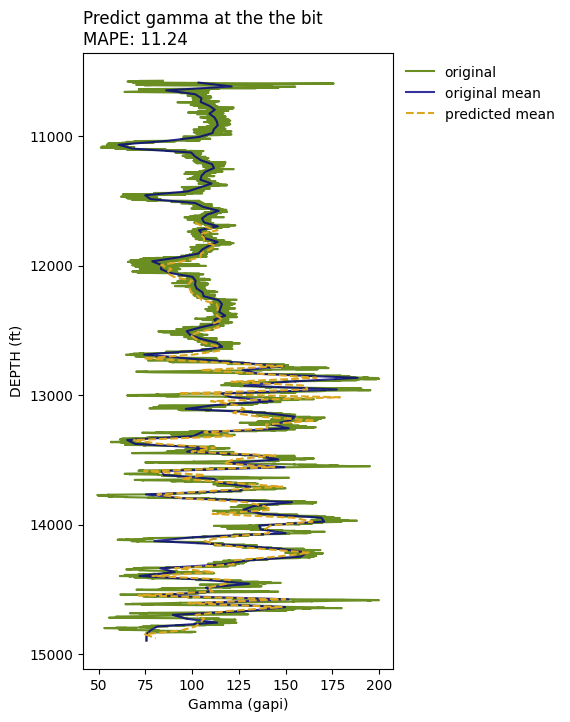

In [36]:
# predict gamma with non-overlapping in 30ft windows  - also can test further windows out via steps variable
df_res=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']]
# for col in list(df_features.columns[df_features.columns.str.contains('Gamma')].str.replace('Gamma(gapi)__','')):
col='mean'
df=df_features
X = df[f'Gamma(gapi)__{col}'].values
# split into train and test sets
size = int(len(X) * 0.25)
train, test = X[0:size], X[size:len(X)]
history = list(train)
predictions = list()
# walk-forward validation
steps=0## test predicting values further out from bit(step = 1 window)
prediction_step=[]
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0)) # ARIMA model parameters not optimized - Proof of concept only
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t] #real obs
    history.append(obs)
    if steps !=0:
        yhats=[yhat]
        for i in range(steps):
            model = ARIMA(history+yhats, order=(5,1,0))
            model_fit = model.fit()
            output = model_fit.forecast()
            yhats.append(output[0])
            if i == (steps-1):
                prediction_step.append(output[0])

if steps!=0:       
    predictions=prediction_step
    a = np.empty(steps)
    a[:] = np.nan
    predictions=list(a)+predictions[:-steps]
        
# plot forecasts against actual outcomes
fig,ax=plt.subplots(figsize=(4,8))
ax.plot(df_horz['Gamma(gapi)'],df_horz['DEPTH(ft)'], color='olivedrab',label='original')
ax.plot(pd.Series(X),df[f'DEPTH(ft)__{col}'],label=f'original {col}',color='navy',alpha=.8)
# plt.plot(test)
predictions=pd.Series(predictions)
predictions.index=range(len(train),len(train)+len(predictions))
df[f'pred__{col}']=predictions
ax.plot(df[f'pred__{col}'],df[f'DEPTH(ft)__{col}'], color='goldenrod',label=f'predicted {col}',alpha=1,linestyle='--')
ax.set_xlabel('Gamma (gapi)')
ax.set_ylabel('DEPTH (ft)')
ax.invert_yaxis()
ax.legend(bbox_to_anchor=(1,1),frameon=False)
# compare raw value to predicted value 
pred_df=df[df[f'pred__{col}'].notna()]
pred_df['DEPTH(ft)__mean']=pred_df['DEPTH(ft)__mean']-.25 ## correct for tsfresh calculation - can fix manually later
final=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']].merge(pred_df[['DEPTH(ft)__mean','pred__mean']],right_on='DEPTH(ft)__mean',left_on='DEPTH(ft)')
print(sqrt(mean_squared_error(final['Gamma(gapi)'], final[f'pred__{col}'])))
per_err=np.abs((final['Gamma(gapi)']-final[f'pred__mean'])/final['Gamma(gapi)'])
per_err=100*(np.sum(per_err)/len(per_err))
ax.set_title(f'Predict gamma at the the bit\nMAPE: {(np.round(per_err,2))}',loc='left')
final1=final.drop(columns=['DEPTH(ft)__mean'])
final1.rename(columns={'pred__mean':'predicted gamma'},inplace=True)

# final1.to_csv(f'results/mean_nonoverlaping_window_predictgamma_30ftahead_ofbit{file_names[0]}.csv')


In [38]:
final1

,DEPTH(ft),Gamma(gapi),predicted gamma
0,11667.0,102.9185,101.480602
1,11697.0,119.5879,105.693704
2,11727.0,101.5785,113.596067
3,11757.0,106.2714,104.216746
4,11787.0,107.5259,106.417668
...,...,...,...
102,14757.0,120.5377,104.336492
103,14787.0,74.3695,101.753885
104,14817.0,80.6698,94.124105
105,14847.0,75.6183,74.703911


In [37]:
# overlapping prediction
# df=df_horz[:200].reset_index(drop=True)
combine=pd.DataFrame(df_horz_orig['DEPTH(ft)'])
for df_features in dfs:
    df=df_features
    X = df['Gamma(gapi)__mean'].values
    # split into train and test sets
    size = int(len(X) * 0.25)
    train, test = X[0:size], X[size:len(X)]
    history = list(train)
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t] #real obs
        history.append(obs)

    predictions=pd.Series(predictions)
    predictions.index=range(len(train),len(train)+len(predictions))
    df['pred']=predictions
    df=df[['DEPTH(ft)__mean','Gamma(gapi)__mean','pred']]
    df=df.rename(columns={'DEPTH(ft)__mean':'DEPTH(ft)'})
    combine=pd.concat([df,combine])
combined=combine[combine['Gamma(gapi)__mean'].notna()].sort_values('DEPTH(ft)')

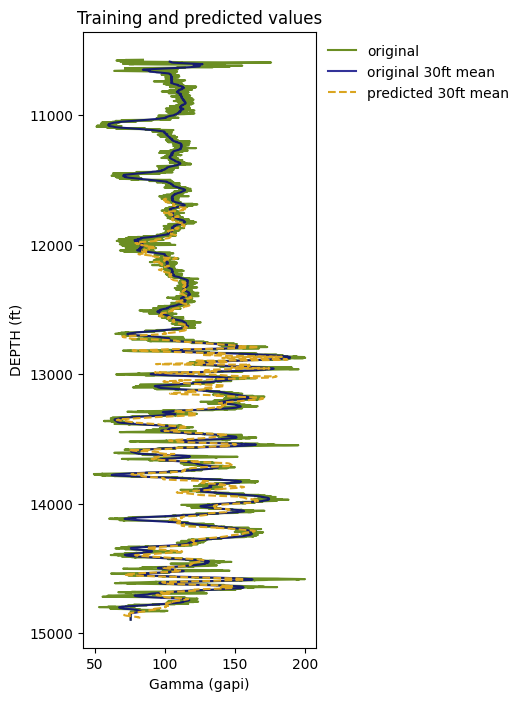

In [ ]:
fig, ax=plt.subplots(figsize=(3,8))
ax.plot(df_horz_orig['Gamma(gapi)'],df_horz_orig['DEPTH(ft)'], color='olivedrab',label='original')
ax.plot(combined['Gamma(gapi)__mean'],combined['DEPTH(ft)'],label='original 30ft mean',color='navy',alpha=.8)
ax.plot(combined['pred'],combined['DEPTH(ft)'], color='goldenrod',label='predicted 30ft mean',alpha=1,linestyle='--')
ax.set_xlabel('Gamma (gapi)')
ax.set_ylabel('DEPTH (ft)')
ax.set_title('Training and predicted values')
ax.invert_yaxis()
ax.legend(bbox_to_anchor=(1,1),frameon=False)
c=combined.dropna()
rmse = sqrt(mean_squared_error(c['Gamma(gapi)__mean'], c['pred']))
rmse

## Explore other gamma window features 

In [4]:
df_features_all = extract_features(df_horz1, column_id="id", column_sort="DEPTH(ft)_time")


Feature Extraction: 100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


In [5]:
df_all_gamma_features=df_features_all[list(df_features_all.columns[df_features_all.columns.str.contains('Gamma')])+['DEPTH(ft)__mean']]


In [6]:

rmse={}
err=[]
for i in range(0,len(df_all_gamma_features.columns)-1):
    try: 
        df=df_all_gamma_features
        col=df.columns[i]
        X = df[col].values
        # split into train and test sets
        size = int(len(X) * 0.25)
        train, test = X[0:size], X[size:len(X)]
        history = list(train)
        predictions = list()
        # walk-forward validation
        for t in range(len(test)):
            model = ARIMA(history, order=(5,1,0))
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t] #real obs
            history.append(obs)
        predictions=pd.Series(predictions)
        predictions.index=range(len(train),len(train)+len(predictions))
        df['pred']=predictions
        # evaluate forecasts
        # convert agg data to raw shape
        pred_df=df[df['pred'].notna()]
        raws=pd.DataFrame()
        for i in range(0,pred_df.shape[0]):
            current_depth=pred_df['DEPTH(ft)__mean'].iloc[i]
            depth=np.concatenate([np.arange(current_depth-15,current_depth,.5),np.arange(current_depth,current_depth+15,.5)])
            raw=pd.DataFrame(depth,columns=['DEPTH(ft)'])
            raw['pred']=pred_df['pred'].iloc[i]
            raws=pd.concat([raws,raw])
        raws['DEPTH(ft)']=raws['DEPTH(ft)']-.25
        pred_df_raw=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']].merge(raws,on='DEPTH(ft)')
        rmse[col]=sqrt(mean_squared_error(pred_df_raw['Gamma(gapi)'], pred_df_raw['pred']))
    except:
        err.append(col)
    
rmse=pd.DataFrame(rmse,index=[0]).T.reset_index()
rmse.columns=['feature','rmse']
fn=file_names[0].replace('.csv','')
rmse.to_csv(f'results/{fn}_30ftwindow_nonoverlap_all_features_gamma.csv')
if len(err)!=0:
    pd.Series(err).to_csv(f'results/{fn}_errors_30ftwindow_nonoverlap_all_features_gamma.csv')

In [17]:
a=pd.read_csv(f'results/{fn}_30ftwindow_nonoverlap_all_features_gamma.csv',index_col=[0])
a.sort_values('rmse').iloc[0:20]

,feature,rmse
87,Gamma(gapi)__quantile__q_0.6,19.259777
9,Gamma(gapi)__median,19.515623
16,Gamma(gapi)__root_mean_square,19.638602
428,"Gamma(gapi)__agg_linear_trend__attr_""intercept...",19.688837
88,Gamma(gapi)__quantile__q_0.7,19.856873
10,Gamma(gapi)__mean,19.920015
86,Gamma(gapi)__quantile__q_0.4,21.154548
89,Gamma(gapi)__quantile__q_0.8,21.638145
85,Gamma(gapi)__quantile__q_0.3,22.621749
90,Gamma(gapi)__quantile__q_0.9,24.024807


In [8]:
pd.read_csv(f'results/{fn}_errors_30ftwindow_nonoverlap_all_features_gamma.csv',index_col=[0])

,0
0,Gamma(gapi)__variance
1,Gamma(gapi)__partial_autocorrelation__lag_6
2,Gamma(gapi)__spkt_welch_density__coeff_2
3,"Gamma(gapi)__fft_coefficient__attr_""real""__coe..."
4,"Gamma(gapi)__fft_coefficient__attr_""real""__coe..."
...,...
282,"Gamma(gapi)__fft_coefficient__attr_""angle""__co..."
283,Gamma(gapi)__max_langevin_fixed_point__m_3__r_30
284,"Gamma(gapi)__agg_linear_trend__attr_""intercept..."
285,"Gamma(gapi)__agg_linear_trend__attr_""slope""__c..."


In [57]:
### do overlapping window with combined features!! 
combine=pd.DataFrame(df_horz_orig['DEPTH(ft)'])
for df_features in dfs:
    df_feature= df_features[['DEPTH(ft)__mean']+list(df_features.columns[df_features.columns.str.contains('Gamma')])]
    size=int(len(df_feature) * 0.25)
    train=df_feature[:size]
    test=df_feature[size:]

    # Fit a simple auto_arima model
    arima = pm.auto_arima(train['Gamma(gapi)__mean'],X=train.drop(columns=['DEPTH(ft)__mean','Gamma(gapi)__mean']), d=2,error_action='ignore', trace=False,
                        suppress_warnings=True, maxiter=500,stationary=False,test='adf')
    pred=arima.predict(n_periods=108, X=test.drop(columns=['DEPTH(ft)__mean','Gamma(gapi)__mean']), alpha=0.05)
    prediction=pd.DataFrame(pred).reset_index(drop=True)
    df=test.reset_index(drop=True)
    df['pred']=prediction[0]
    df=df[['DEPTH(ft)__mean','Gamma(gapi)__mean','pred']]
    df=df.rename(columns={'DEPTH(ft)__mean':'DEPTH(ft)'})
    combine=pd.concat([df,combine])
combined=combine[combine['Gamma(gapi)__mean'].notna()].sort_values('DEPTH(ft)')

    # # # convert agg data to raw shape
    # # pred_df=test
    # # raws=pd.DataFrame()
    # # for i in range(0,pred_df.shape[0]):
    # #     current_depth=pred_df[f'DEPTH(ft)__mean'].iloc[i]
    # #     depth=np.concatenate([np.arange(current_depth-15,current_depth,.5),np.arange(current_depth,current_depth+15,.5)])
    # #     raw=pd.DataFrame(depth,columns=['DEPTH(ft)'])
    # #     raw['Prediction']=pred_df['Prediction'].iloc[i]
    # #     raws=pd.concat([raws,raw])
    # # raws['DEPTH(ft)']=raws['DEPTH(ft)']-.25
    # # pred_df_raw=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']].merge(raws,on='DEPTH(ft)').dropna()
    # rmse=sqrt(mean_squared_error(pred_df_raw['Gamma(gapi)'], pred_df_raw['Prediction']))
    
    

In [58]:
pred_df=combined
pred_df['DEPTH(ft)']=pred_df['DEPTH(ft)']-.25 ## correct for tsfresh calculation - can fix manually later
final=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']].merge(pred_df[['DEPTH(ft)','pred']],on='DEPTH(ft)')
print(sqrt(mean_squared_error(final['Gamma(gapi)'], final[f'pred'])))
per_err=np.abs((final['Gamma(gapi)']-final[f'pred'])/final['Gamma(gapi)'])
per_err=100*(np.sum(per_err)/len(per_err))
ax.set_title(f'Predict gamma at the the bit\nMAPE: {(np.round(per_err,2))}',loc='left')
final1.rename(columns={'pred':'predicted gamma'},inplace=True)
print(per_err)
final1.to_csv(f'results/descriptive_overlapping_window_gammaatbit_{file_names[0]}.csv')

9.020301517590662
6.270445830419493


In [61]:
final1.head()

,DEPTH(ft),Gamma(gapi),predicted gamma
0,11667.0,102.9185,101.480602
1,11697.0,119.5879,105.693704
2,11727.0,101.5785,113.596067
3,11757.0,106.2714,104.216746
4,11787.0,107.5259,106.417668


3.2018185394884395


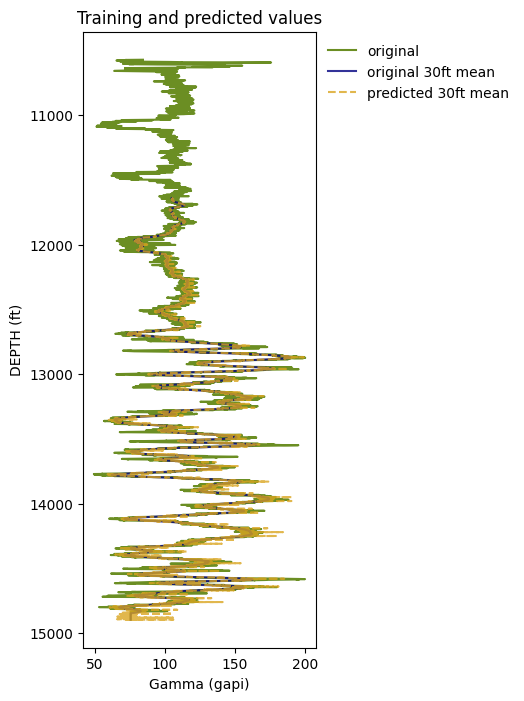

In [60]:
fig, ax=plt.subplots(figsize=(3,8))
ax.plot(df_horz_orig['Gamma(gapi)'],df_horz_orig['DEPTH(ft)'], color='olivedrab',label='original')
ax.plot(combined['Gamma(gapi)__mean'],combined['DEPTH(ft)'],label='original 30ft mean',color='navy',alpha=.8)
ax.plot(combined['pred'],combined['DEPTH(ft)'], color='goldenrod',label='predicted 30ft mean',alpha=.8,linestyle='--')
ax.set_xlabel('Gamma (gapi)')
ax.set_ylabel('DEPTH (ft)')
ax.set_title('Training and predicted values')
ax.invert_yaxis()
ax.legend(bbox_to_anchor=(1,1),frameon=False)
c=combined.dropna()
rmse = sqrt(mean_squared_error(c['Gamma(gapi)__mean'], c['pred']))
print(rmse) #note this rmse is on mean gamma not raw gamma that is why it is artificially good


In [31]:
## check that combined represents raw data shape


In [9]:
# actual rmse
combined['DEPTH(ft)']=combined['DEPTH(ft)']+.25
final=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']].merge(combined,on='DEPTH(ft)')
sqrt(mean_squared_error(final['Gamma(gapi)'], final['pred']))

9.015257233485704